In [ ]:
Perceptron(10)

In [91]:
file_path  =r"C:\workspace\django_workspace\prototype4_\framework\PearMountEngine\Dataset\iris.csv"
query = "TirionFordring$DMLP$InputLayer_CSV(y_label_index_starting=4, y_label_index_last=4)§Perceptron(hidden_layer_num=10)§Activation_Relu()§Perceptron(final_layer=True)§Activation_Sigmoid()§MeanSquaredError()§PerceptronParameter(learning_rate=0.001, batch_size=10, epochs=100, optimizer='SGD', accuracy_limit=90)"

In [92]:
#### ParentClass 이름 불러오는 메쏘드
class util:
    def print_base(class_name):
        for base in class_name.__class__.__bases__:
            return base.__name__

In [93]:

class LoopController:
#     full_layer = []
#     train_loss_list = []
#     train_acc_list = []
#     test_acc_list = []
#     param = None
    
    def __init__(self, file_path, query):
        self.file_path = file_path
        self.query = query
        
        self.session = self.query.split("$")[0]
        self.network = self.query.split("$")[1] #DMLP, CNN, RNN.. 
        string_to_pass = self.query.split("$")[2].split("§")
        
        self.full_layer = []
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        self.param = None
        
        for string in string_to_pass:
            string_class =eval(string)
            if util.print_base(string_class) == "InputLayer":
                self.x_train, self.y_train, self.x_test, self.y_test = string_class.build_layer(self.file_path)
                
            elif util.print_base(string_class) == "Parameter":
                self.param = string_class.get_parameter()
                
            else:
                self.full_layer.append(string)        
        
    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        
        grads = self.learn_net.gradient(x_batch, y_batch)
        self.optimizer.update(self.learn_net.weight_layer, grads)
        
        loss = self.learn_net.loss(x_batch, y_batch)
        self.train_loss_list.append(loss)
        
        print("train loss: " + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch +=1
            
            x_train_sample, y_train_sample = self.x_train, self.y_train
            x_test_sample, y_test_sample = self.x_test, self.y_test
            
            train_acc = self.learn_net.accuracy(x_train_sample, y_train_sample)
            test_acc = self.learn_net.accuracy(x_test_sample, y_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            
            print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
            
            
        self.current_iter += 1
            
            
        
        
        
    def learn(self):
        self.learn_net = eval(self.network)(self.full_layer)
        self.learn_net.build_model(self.x_train, self.y_train)
#         print("build_model 완료")
        
        self.epochs = self.param["epochs"]
        self.batch_size = self.param["batch_size"]
        self.learning_rate = self.param["learning_rate"]
        self.optimizer = eval(self.param["optimizer"])(self.learning_rate)
        
        self.train_size = self.x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / self.batch_size, 1)
        self.max_iter = int(self.epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        for i in range(self.max_iter):
            self.train_step()
            if self.param["accuracy_limit"] != None:
                if self.test_acc_list[-1] >= self.param["accuracy_limit"]*0.01:
                    print("Reached accuracy_limit")
                    break
            
        test_acc = self.learn_net.accuracy(self.x_test, self.y_test)
        
        print("=====Final Test Accuracy====")
        print("test acc: "+str(test_acc))
        
        
        
            
        
        
        
        
                

In [94]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:
#### ParentClass 이름 불러오는 메쏘드
import collections

class DMLP:
    def __init__(self, full_layer):
        self.full_layer = full_layer
        self.hidden_size_list = []
        
        self.weight_layer = {}                  #weight의 모음
        self.layers = collections.OrderedDict() #쌓여있는 층
        self.final_layer = None             #costlayer가 담겨있는 층
        
    def build_model(self, x, y, random_seed = 3, weight_init_std='sigmoid', weight_decay_lambda=0):
        #난수 생성할때 랜덤값 고정하기, 평소에는 이거 지우면 된다. 
#         np.random.seed(random_seed)
        self.weight_decay_lambda = weight_decay_lambda
        
        for sum_class in self.full_layer:
            if util.print_base(eval(sum_class)) == "SummationLayer":
                hidden = eval(sum_class).pass_hidden_layer_num()
                if hidden == "final_layer":
                    hidden = y.shape[-1]
                self.hidden_size_list.append(hidden)
        
        self.input_size = x.shape[-1]
        self.hidden_layer_num = len(self.hidden_size_list)
        
        #가중치 초기화
        self.__init_weight(weight_init_std)
        
        #계층 생성
        sum_idx = 1
        act_idx = 1
        for sum_class in self.full_layer:
            if util.print_base(eval(sum_class)) == "SummationLayer":
                self.layers['Perceptron' + str(sum_idx)] = eval(sum_class)
                self.layers['Perceptron' + str(sum_idx)].update(self.weight_layer['W' + str(sum_idx)],self.weight_layer['b' + str(sum_idx)])
                sum_idx+=1
            elif util.print_base(eval(sum_class)) == "ActivationLayer":
                self.layers['Activation_function' + str(act_idx)] = eval(sum_class)
                act_idx+=1
                
            elif util.print_base(eval(sum_class)) == "CostLayer":
                self.final_layer = eval(sum_class)
        
        
    
    ##가중치 초기화
    def __init_weight(self, weight_init_std):
        '''
        가중치 초기화할때 표준편차를 지정하는 것도 아주 중요한 파라미터.
        'relu'일때는 'He 초깃값'
        'sigmoid'일때는 'Xavier 초깃값'
        '''
        all_size_list = [self.input_size] + self.hidden_size_list  
        print(all_size_list)
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ("sigmoid"):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  #sigmoid사용할때 초깃값
            elif str(weight_init_std).lower() in ("relu"):
                scale = np.sqrt(2.0 / all_size_list[idx -1])   #relu사용할 때 권장값
                
            self.weight_layer['W'+str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.weight_layer['b' + str(idx)] = np.zeros(all_size_list[idx])
            
#             print("weight값: "+str(self.weight_layer))
     
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    
    def loss(self,x,y):
        y_hat = self.predict(x)
        
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 1):
            W = self.weight_layer['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
            
        return self.final_layer.forward(y_hat, y) + weight_decay
    
    
    def accuracy(self,x, y):
        y_hat = self.predict(x)
        y_hat = (y_hat == y_hat.max(axis=1)[:,None]).astype(int)
        accuracy = np.all(y_hat == y, axis=1)
        
        return np.sum(accuracy)/len(accuracy)
    
    
    
    def gradient(self, x, y):
        #forward
        self.loss(x,y)
        
        #backward
        gradient = 1
        gradient = self.final_layer.backward(gradient)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            gradient = layer.backward(gradient)
            
        grads = {}
        for idx in range(1, self.hidden_layer_num+1):
            grads['W' + str(idx)] = self.layers['Perceptron' + str(idx)].weight_gradient + self.weight_decay_lambda * self.layers["Perceptron" + str(idx)].weight
            
            grads['b' + str(idx)] = self.layers['Perceptron'+str(idx)].bias_gradient
            
        return grads
        



In [95]:
test = LoopController(file_path, query)
test.learn()

[4, 10, 3]
train loss: 4.5987006643804955
=== epoch:1, train acc:0.34444444444444444, test acc:0.4 ===
train loss: 3.822554280148707
train loss: 5.35961499267525
train loss: 6.040540927144539
train loss: 5.491470266416775
train loss: 4.8674057748752055
train loss: 5.236646737738923
train loss: 3.619297530609515
train loss: 4.770245604053582
train loss: 4.561553982455839
=== epoch:2, train acc:0.34444444444444444, test acc:0.4 ===
train loss: 5.449105855107102
train loss: 5.254599565939041
train loss: 6.124763897057135
train loss: 3.7639381955822335
train loss: 3.7230794084722842
train loss: 3.3901877997989622
train loss: 5.355207914135293
train loss: 4.813409469315956
train loss: 4.589771940857693
=== epoch:3, train acc:0.34444444444444444, test acc:0.4 ===
train loss: 4.698531836307386
train loss: 5.384481082092766
train loss: 4.8696563599731215
train loss: 4.115182846150958
train loss: 3.7330090698664855
train loss: 3.8060107265009635
train loss: 4.861669034607023
train loss: 5.25066

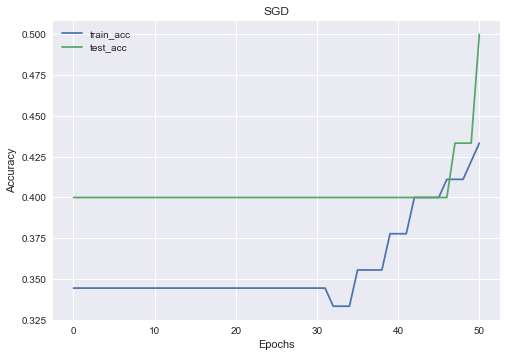

In [96]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(test.train_acc_list, label="train_acc")
plt.plot(test.test_acc_list, label="test_acc")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("SGD")
plt.show()

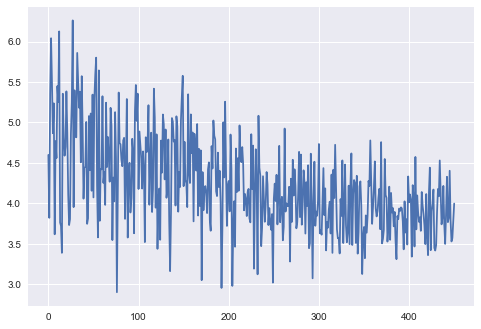

In [97]:
plt.plot(test.train_loss_list, label="train_loss")

In [72]:
optimizer = ["SGD","Momentum","NAG","AdaGrad","RMSprop","Adam"]
new = dict()
for opt in optimizer:
    file_path = file_path
    query = "TirionFordring$DMLP$InputLayer_CSV(y_label_index_starting=4, y_label_index_last=4)§Perceptron(hidden_layer_num=10)§Activation_Relu()§Perceptron(final_layer=True)§Activation_Sigmoid()§MeanSquaredError()§PerceptronParameter(learning_rate=0.001, batch_size=10, epochs=100, optimizer='"+opt+"')"
    query = str(query)
    a = LoopController(file_path,query)
    a.learn()
    new[a.param['optimizer']]=a.test_acc_list
    

[4, 10, 3]
train loss: 3.933399140967781
=== epoch:1, train acc:0.17777777777777778, test acc:0.3333333333333333 ===
train loss: 4.116122658241115
train loss: 4.072332913161946
train loss: 4.295735059554384
train loss: 4.272727081208288
train loss: 3.850866143614928
train loss: 3.881245014914913
train loss: 3.726041576409269
train loss: 4.0803862081492674
train loss: 4.135044841167566
=== epoch:2, train acc:0.18888888888888888, test acc:0.3333333333333333 ===
train loss: 3.5124764990627235
train loss: 3.751276653204434
train loss: 3.864142019902329
train loss: 4.099601633645444
train loss: 4.080639039957171
train loss: 4.077747999067333
train loss: 4.497469086167783
train loss: 4.003848739292145
train loss: 3.9553149976062563
=== epoch:3, train acc:0.2111111111111111, test acc:0.36666666666666664 ===
train loss: 4.0145781223227335
train loss: 4.303519183064934
train loss: 4.057521092677258
train loss: 3.692010619642164
train loss: 3.925631210177777
train loss: 3.7119091274632385
train 

train loss: 3.4463569975321375
train loss: 3.325086734402477
=== epoch:56, train acc:0.2777777777777778, test acc:0.43333333333333335 ===
train loss: 3.277962418775983
train loss: 3.3431934095538662
train loss: 3.385346020660415
train loss: 3.364903768078516
train loss: 3.219441009181574
train loss: 3.3818564545140983
train loss: 3.505575030378621
train loss: 3.369422750376995
train loss: 3.3477783777054553
=== epoch:57, train acc:0.2777777777777778, test acc:0.43333333333333335 ===
train loss: 3.3885855083472154
train loss: 3.3552534229128037
train loss: 3.2967142305705393
train loss: 3.392413600373426
train loss: 3.310503258058213
train loss: 3.4054730106366176
train loss: 3.2319200172064324
train loss: 3.3452395182608288
train loss: 3.4356656201754263
=== epoch:58, train acc:0.2777777777777778, test acc:0.43333333333333335 ===
train loss: 3.4584880671370906
train loss: 3.440695930264997
train loss: 3.381224822159675
train loss: 3.3663991386271306
train loss: 3.3653085112858037
train

train loss: 3.367533037090299
train loss: 3.437448083450786
train loss: 3.1927238286711694
train loss: 3.221513870903616
train loss: 3.2093601619425445
train loss: 3.2956866569399095
train loss: 3.450524240149499
train loss: 3.1145915401838145
train loss: 2.928843439824039
=== epoch:12, train acc:0.35555555555555557, test acc:0.3 ===
train loss: 3.135741971689355
train loss: 2.9811340766165197
train loss: 3.5395263133493726
train loss: 3.4232220969905938
train loss: 3.536216279124157
train loss: 3.563260044159279
train loss: 3.452793583490052
train loss: 3.3078731204496297
train loss: 3.107066947005971
=== epoch:13, train acc:0.35555555555555557, test acc:0.3 ===
train loss: 3.539967424208713
train loss: 3.1383432172700148
train loss: 3.139358505158576
train loss: 2.72343381753147
train loss: 3.247069992520824
train loss: 3.6320024980003662
train loss: 3.5447695205162937
train loss: 3.0944705971106345
train loss: 3.267723557440418
=== epoch:14, train acc:0.35555555555555557, test acc:0

train loss: 2.228066839868448
train loss: 2.0701517026115357
train loss: 2.067506541242998
train loss: 2.2843946386352467
train loss: 2.2257233698303924
train loss: 2.862773278503085
train loss: 2.349272004222945
train loss: 1.7645852957087516
train loss: 2.5305581775825203
=== epoch:69, train acc:0.6666666666666666, test acc:0.7 ===
train loss: 1.9939766791741969
train loss: 2.3574460876784977
train loss: 1.9527646613144465
train loss: 2.4944782834380517
train loss: 1.9022171658787386
train loss: 2.1177507072195274
train loss: 2.265387681218716
train loss: 1.936456875578134
train loss: 2.226540385091985
=== epoch:70, train acc:0.6666666666666666, test acc:0.7 ===
train loss: 2.3078691089161376
train loss: 2.155525793972581
train loss: 2.6571871687223796
train loss: 2.2132765174525884
train loss: 2.5659285382847288
train loss: 2.4886605611144947
train loss: 2.209621360473104
train loss: 1.8282720579204736
train loss: 2.2752402708372235
=== epoch:71, train acc:0.6666666666666666, test a

train loss: 4.085668439550658
train loss: 3.5915017974122017
train loss: 3.0981320939268406
train loss: 3.6167460598962466
train loss: 3.094650513857144
train loss: 4.50283438762785
=== epoch:23, train acc:0.37777777777777777, test acc:0.26666666666666666 ===
train loss: 4.066669623957529
train loss: 5.421253744721167
train loss: 4.066529157614315
train loss: 3.0433009503571844
train loss: 3.082108918545182
train loss: 4.488054243004507
train loss: 3.4457060863796958
train loss: 3.0195956713162833
train loss: 2.5703297547730553
=== epoch:24, train acc:0.37777777777777777, test acc:0.26666666666666666 ===
train loss: 2.571201012517285
train loss: 3.4577425640419976
train loss: 2.9267531694504045
train loss: 5.215113708310211
train loss: 4.359700407406258
train loss: 4.344960485086465
train loss: 2.362493239419203
train loss: 5.633973477883242
train loss: 4.147499160740513
=== epoch:25, train acc:0.37777777777777777, test acc:0.26666666666666666 ===
train loss: 3.2349270678357582
train l

train loss: 5.2936734106228895
train loss: 5.909272206256262
train loss: 6.4576537663490905
=== epoch:23, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 5.838801397223208
train loss: 5.3777051578023585
train loss: 6.348842276774049
train loss: 6.385614282505326
train loss: 5.156307896735003
train loss: 4.610890219474337
train loss: 5.1199866216171985
train loss: 5.154770139218348
train loss: 5.132266351950656
=== epoch:24, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 5.231630360081154
train loss: 5.528410946205489
train loss: 5.614204641345243
train loss: 6.422554868069181
train loss: 4.68574099135462
train loss: 6.525123819455902
train loss: 4.600874021151638
train loss: 6.2479975900253555
train loss: 5.632434140908694
=== epoch:25, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 5.733712454754052
train loss: 5.115702098979123
train loss: 4.7841047219296815
train loss: 5.176273985108456
train loss: 5.13979870602998
train loss: 5.11004431935429
t

train loss: 4.062273005600618
train loss: 5.1906859247546295
train loss: 5.350979186199648
train loss: 5.0370609795267445
train loss: 4.640046798851782
train loss: 4.695599677476969
=== epoch:76, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 4.160148516978773
train loss: 5.920299359789551
train loss: 5.228955612657229
train loss: 6.307787775611578
train loss: 5.901207577842284
train loss: 4.368336996599749
train loss: 4.579415010675761
train loss: 4.751135432921681
train loss: 4.651342378056031
=== epoch:77, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 4.850482926610382
train loss: 4.161750856372719
train loss: 3.7346212198491724
train loss: 4.6435983545283435
train loss: 5.264018772470343
train loss: 6.5905496572412305
train loss: 3.9148746165727486
train loss: 5.723081826983468
train loss: 5.239976531144882
=== epoch:78, train acc:0.32222222222222224, test acc:0.3 ===
train loss: 5.0541860418357984
train loss: 5.1907536349598695
train loss: 5.773772296016

train loss: 2.1272439648360653
train loss: 1.4837327708783805
train loss: 2.154074859159987
train loss: 2.358630226608206
=== epoch:24, train acc:0.6888888888888889, test acc:0.6 ===
train loss: 1.970693831267096
train loss: 1.74645830130211
train loss: 1.5243746061570287
train loss: 2.2787464973825946
train loss: 2.0023625000300953
train loss: 2.2349453667810035
train loss: 1.1724091239564847
train loss: 1.9971266805666361
train loss: 1.485219206712813
=== epoch:25, train acc:0.6888888888888889, test acc:0.6 ===
train loss: 2.0432831321700586
train loss: 1.7326509059919992
train loss: 2.6391258669179054
train loss: 1.626093450575236
train loss: 2.3174080674772846
train loss: 2.3331156510831974
train loss: 1.8311920504589414
train loss: 2.520570812217662
train loss: 1.7457415946830293
=== epoch:26, train acc:0.6888888888888889, test acc:0.6333333333333333 ===
train loss: 1.997171372326181
train loss: 1.7966696112962643
train loss: 1.8327328717695905
train loss: 1.589234151885532
train 

train loss: 2.0453660848606297
train loss: 1.8744749589351561
train loss: 1.718049622473072
=== epoch:75, train acc:0.7, test acc:0.7 ===
train loss: 2.026554889923746
train loss: 1.5237234296428408
train loss: 1.1999088861649896
train loss: 1.5837541762296066
train loss: 1.4387762270298199
train loss: 1.2787118960976833
train loss: 1.193239323065394
train loss: 1.8236594799500905
train loss: 1.3984168225532765
=== epoch:76, train acc:0.6888888888888889, test acc:0.6 ===
train loss: 1.5432330288075757
train loss: 2.0452397836770295
train loss: 2.297507203041451
train loss: 1.684259105049402
train loss: 1.4029879067765156
train loss: 1.906548517505347
train loss: 1.9504333614025744
train loss: 1.9357822154298097
train loss: 1.3842700615328736
=== epoch:77, train acc:0.7111111111111111, test acc:0.7333333333333333 ===
train loss: 1.613144158488454
train loss: 1.525390287639118
train loss: 1.9510399493018369
train loss: 1.2723573518130784
train loss: 2.1607314310490313
train loss: 1.56231

train loss: 1.9315248476733438
train loss: 2.3642842835210516
train loss: 1.5837210037180176
train loss: 1.824892904691734
train loss: 2.0146953633664535
=== epoch:33, train acc:0.6888888888888889, test acc:0.6666666666666666 ===
train loss: 1.5197187121621814
train loss: 1.3570072055421802
train loss: 2.085117860138108
train loss: 1.6793236853364693
train loss: 1.841756392475629
train loss: 1.8447315158403017
train loss: 1.8982161440075984
train loss: 1.9308070575260181
train loss: 1.7542635972229301
=== epoch:34, train acc:0.6555555555555556, test acc:0.6666666666666666 ===
train loss: 1.5454081943282603
train loss: 1.8646932496577604
train loss: 1.6413927028325177
train loss: 2.0989241175742217
train loss: 2.4270814353918597
train loss: 1.8325749122183521
train loss: 1.8906264161934374
train loss: 2.255005563635315
train loss: 2.415847021681916
=== epoch:35, train acc:0.6555555555555556, test acc:0.6666666666666666 ===
train loss: 1.8883812162422304
train loss: 1.7754445599806048
tr

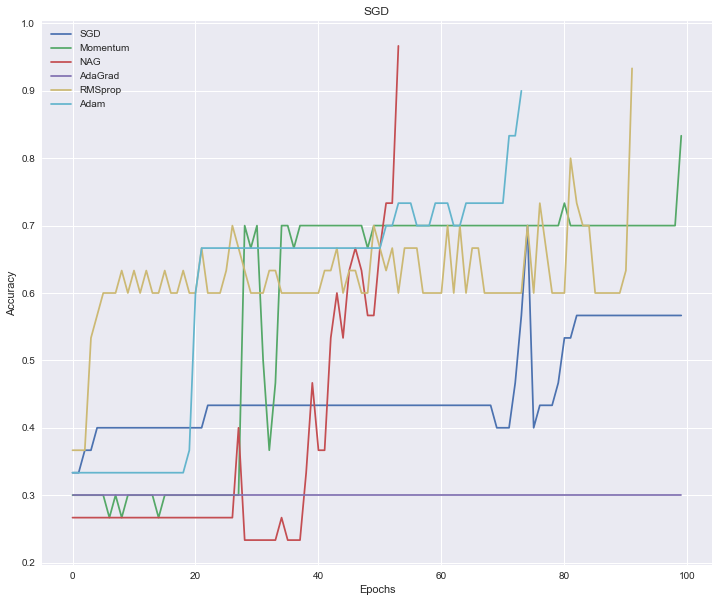

In [84]:
plt.style.use("seaborn")
plt.figure(figsize=(12,10))

# x_ = list(range(max([len(i) for i in new.values()])))

for key, val in new.items():
    key = str(key)
    plt.plot(val, label=key)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("SGD")
plt.show()

In [5]:
#Optimizer
class SGD:
    def __init__(self, learning_rate=0.1):
        self.learning_rate = learning_rate
        
    def update(self, weight_layer, grads):
        for key in weight_layer.keys():
            weight_layer[key] -= self.learning_rate * grads[key] 
            
            
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = None
        
    def update(self, weight_layer, grads):
        if self.v is None:
            self.v = {}
            for key, val in weight_layer.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in weight_layer.keys():
            self.v[key] = self.momentum*self.v[key] - self.learning_rate*grads[key] 
            weight_layer[key] += self.v[key]


class NAG:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = None
        
    def update(self, weight_layer, grads):
        if self.v is None:
            self.v = {}
            for key, val in weight_layer.items():
                self.v[key] = np.zeros_like(val)
            
        for key in weight_layer.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.learning_rate * grads[key]
            weight_layer[key] += self.momentum * self.momentum * self.v[key]
            weight_layer[key] -= (1 + self.momentum) * self.learning_rate * grads[key]


class AdaGrad:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.h = None
        
    def update(self, weight_layer, grads):
        if self.h is None:
            self.h = {}
            for key, val in weight_layer.items():
                self.h[key] = np.zeros_like(val)
            
        for key in weight_layer.keys():
            self.h[key] += grads[key] * grads[key]
            weight_layer[key] -= self.learning_rate * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:
    def __init__(self, learning_rate=0.01, decay_rate = 0.99):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, weight_layer, grads):
        if self.h is None:
            self.h = {}
            for key, val in weight_layer.items():
                self.h[key] = np.zeros_like(val)
            
        for key in weight_layer.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            weight_layer[key] -= self.learning_rate * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, weight_layer, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in weight_layer.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        learning_rate_t  = self.learning_rate * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in weight_layer.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            weight_layer[key] -= learning_rate_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #weight_layer[key] += self.learning_rate * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [6]:
#SummationLayer
class SummationLayer:
    weight_dict = {}
    pass
    
class Perceptron(SummationLayer):
    def __init__(self, hidden_layer_num=10, final_layer=False):
        self.hidden_layer_num = hidden_layer_num
        self.final_layer = final_layer
        self.original_x_shape = None
        self.x = None
        
        self.weight = None
        self.bias = None
        
        self.weight_gradient = None
        self.bias_gradient = None
        
    def update(self, weight, bias):
        self.weight = weight
        self.bias = bias
        
        
    def pass_hidden_layer_num(self):
        if self.final_layer == True:
            hidden_layer_num = "final_layer"
        else:
            hidden_layer_num = self.hidden_layer_num
        
        return hidden_layer_num
    
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        out = np.dot(self.x, self.weight) + self.bias
        
        return out
    
    def backward(self, gradient):
        dot_matrix= np.dot(gradient, self.weight.T)
        self.weight_gradient = np.dot(self.x.T, gradient)
        self.bias_gradient = np.sum(gradient, axis=0)
        
        dot_matrix = dot_matrix.reshape(*self.original_x_shape)
        
        return dot_matrix
    
        

In [7]:
#Activation
class ActivationLayer:
    pass
class Activation_Sigmoid(ActivationLayer):
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, gradient):
        dx = gradient * (1.0 - self.out) * self.out
        return dx
    
    
class Activation_Relu(ActivationLayer):
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [8]:
#CostLayer
class CostLayer:
    loss = None   #손실함수
    y_hat = None  #출력 값
    y = None      #정답 레이블(one-hot encoding형태)
    
class MeanSquaredError(CostLayer):
    def __init__(self):
        pass
    def forward(self, y_hat, y):
        self.y_hat = y_hat
        self.y = y
        self.loss = 0.5 * np.sum((y_hat-y)**2)
        return self.loss
    
    def backward(self, gradient=1):
        batch_size = self.y.shape[0]
        if self.y.size == self.y_hat.size:
            dx = (self.y_hat - self.y)/batch_size
        else:
            dx = self.y_hat.copy()
            dx[np.arage(batch_size), self.y]-=1
            dx = dx/batch_size
        
        return dx

In [35]:
#Parameter Layer
class Parameter:
    param = dict()
class PerceptronParameter(Parameter):
    def __init__(self,learning_rate=0.1, batch_size=10, epochs=10, optimizer="sgd", accuracy_limit=None):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.accuracy_limit = accuracy_limit
        
    def get_parameter(self):
        self.param["learning_rate"] = self.learning_rate
        self.param["batch_size"] = self.batch_size
        self.param["epochs"] = self.epochs
        self.param["optimizer"] = self.optimizer
        self.param["accuracy_limit"] = self.accuracy_limit
        return self.param

In [10]:
#Input Layer
import numpy as np
import csv
from collections.abc import Iterable
import random

class InputLayer:
    y_label_starting = None
    y_label_last = None

    y_label_shape = None

    training_input_matrix = None
    training_y_label = None

    validation_input_matrix = None
    validation_y_label = None

    test_input_matrix = None
    test_y_label = None

    one_hot_encoding_mappings = dict()
    one_hot_encoding_mappings_for_prediction = dict()
    y_label_mappings = dict()
    y_label_mappings_for_prediction = dict()

    returning_shape = None


class InputLayer_CSV(InputLayer):
    def __init__(self, y_label_index_starting, y_label_index_last):
        self.y_label_starting = y_label_index_starting
        self.y_label_last = y_label_index_last

    def build_layer(self, csv_path, train_validation_test_ratio=(6,2,2)):
        y_label_index_starting = self.y_label_starting
        y_label_index_last = self.y_label_last

        def csv_to_header_and_data(csv_path):
            file_instance = open(csv_path)
            rdr = csv.reader(file_instance)
            raw_data = [i for i in rdr]
            return raw_data[0], raw_data[1:], len(raw_data[0])


        def typecast_data_accordingly(header, data):
            output = []
            for each_row in data:
                for index in range(len(header)):
                    if header[index] == 'string':
                        each_row[index] = str(each_row[index])
                        continue
                    if header[index] == 'number':
                        each_row[index] = float(each_row[index])
                output.append(each_row)
            return output


        def encoding_rules(header, data):
            all_mappings = dict()
            all_mappings_reverse = dict()

            for header_index in range(len(header)):
                if header[header_index] == 'number':
                    continue

                string_to_one_hot_encoding = dict()
                one_hot_encoding_to_string = dict()

                temp = set()
                for each_list in data:
                    temp.add(each_list[header_index])

                counter = 0
                for i in temp:
                    cal = list(np.zeros(len(temp)))
                    cal[counter] = 1
                    string_to_one_hot_encoding[i] = cal
                    one_hot_encoding_to_string[tuple(cal)] = i
                    counter += 1

                #행번호 밑에 각 string 별 변환해야 할 one-hot-encoding이 딕셔너리로 적혀있다.
                all_mappings[header_index] = string_to_one_hot_encoding
                all_mappings_reverse[header_index] = one_hot_encoding_to_string
            return all_mappings, all_mappings_reverse

        def flatten(items):
            """My homage to pylang of Stack Overflow"""
            for x in items:
                if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
                    for sub_x in flatten(x):
                        yield sub_x
                else:
                    yield x

        def apply_flattening(data, encoding_rules):
            for column_index in encoding_rules:
                for row_index in range(len(data)):
                    data[row_index][column_index] = encoding_rules[column_index][data[row_index][column_index]]

            for row_index in range(len(data)):
                data[row_index] = list(flatten(data[row_index]))
            return data

        def assign_train_evaluation_test(data, ratio):
            random.shuffle(data)
            train_last_index = round(len(data)/sum(ratio)*ratio[0])
            evaluation_last_index = train_last_index + round(len(data) / sum(ratio) * ratio[1])
            test_last_index = evaluation_last_index + round(len(data) / sum(ratio) * ratio[2])
            return data[:train_last_index], data[train_last_index:evaluation_last_index], data[evaluation_last_index:test_last_index]

        #JSP에서 코딩해서 보낼 때 index는 0번부터 시작하게 하기. 꼭 확인해야함.
        def seperate_y_label_and_arrayfy(data, y_label_starting, y_label_last, original_array_length, encoding_rule):
            value_to_add = 0
            if y_label_starting == 0:
                for index in encoding_rule:
                    if index <= y_label_last:
                        value_to_add += (len(encoding_rule[index])-1)
                else:
                    y_label_last += value_to_add
                    return np.array([i[y_label_last+1:] for i in  data]), np.array([i[:y_label_last+1] for i in data])

            elif y_label_last+1 == original_array_length:
                for index in encoding_rule:
                    if index < y_label_starting:
                        value_to_add += (len(encoding_rule[index])-1)
                else:
                    y_label_starting += value_to_add
                    return np.array([i[:y_label_starting] for i in data]), np.array([i[y_label_starting:] for i in data])


        header, data, original_array_length = csv_to_header_and_data(csv_path)
        data = typecast_data_accordingly(header, data)
        self.one_hot_encoding_mappings, self.one_hot_encoding_mappings_for_prediction = encoding_rules(header, data)
        data = apply_flattening(data, self.one_hot_encoding_mappings)
        train, evaluation, test = assign_train_evaluation_test(data, train_validation_test_ratio)

        self.training_input_matrix, self.training_y_label = \
            seperate_y_label_and_arrayfy(train, y_label_index_starting, y_label_index_last, original_array_length, self.one_hot_encoding_mappings)
        self.validation_input_matrix, self.validation_y_label = \
            seperate_y_label_and_arrayfy(evaluation, y_label_index_starting, y_label_index_last, original_array_length, self.one_hot_encoding_mappings)
        self.test_input_matrix, self.test_y_label = \
            seperate_y_label_and_arrayfy(test, y_label_index_starting, y_label_index_last, original_array_length, self.one_hot_encoding_mappings)

        #print(self.training_input_matrix)
        #print(self.training_y_label)

        #print(self.training_y_label)

        #hard-coded for 1D-data only
        self.returning_shape = self.training_input_matrix[0].reshape(1,-1).shape
        self.y_label_shape = self.training_y_label[0].reshape(1,-1).shape
        if self.one_hot_encoding_mappings != {}:
            self.y_label_mappings = self.one_hot_encoding_mappings[self.y_label_starting]
            self.y_label_mappings_for_prediction = self.one_hot_encoding_mappings_for_prediction[self.y_label_starting]
            
        return self.training_input_matrix, self.training_y_label, self.test_input_matrix, self.test_y_label